# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# загрузим данные
labels = pd.read_csv('/content/drive/MyDrive/Datasets/labels.csv', index_col = 0).reset_index(drop = True)
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = '/content/drive/MyDrive/Datasets/fotos/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        seed = 12345)

Found 7591 validated image filenames.


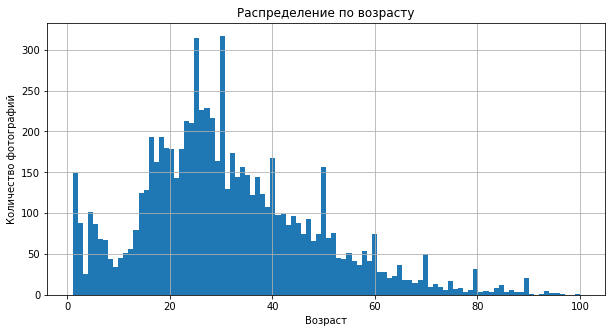

In [6]:
# изучим распределение по возрасту в датасете
labels.real_age.hist(bins = 100, figsize = (10, 5))
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий');

In [7]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [12]:
# выделим признаки и целевой признак
features, target = next(train_gen_flow)

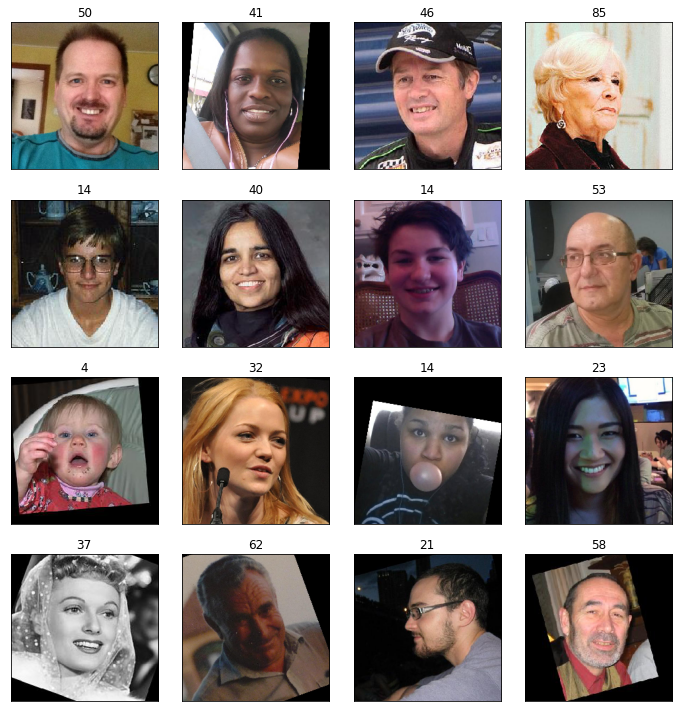

In [13]:
# выведем несколько фотографий с указанием возраста
fig = plt.figure(figsize = (10,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете более 7,5 тысяч фотографий.

Есть много фотографий людей в возрасте от подросткового (13-15 лет) до 45-50 лет. А вот некоторые возраста старше 70 лет представлены всего несколькими фото. Вероятно, модели будет сложнее точно определить возраст пожилых людей. Возможно, имеет смысл использовать аугментацию, чтобы увеличить количество примеров для обучения модели.

Как видим на примере нескольких выведенных на экран фото, в датасете представлены фотографии разного качества. Некоторые нечеткие, с плохим освещением, повернутые влево или вправо, есть черно-белые фото. Люди сфотографированы анфас, в профиль или вполоборота. Часть лица бывает закрыта волосами, головными уборами, очками или посторонними предметами.

Задача кажется довольно сложной. Посмотрим, насколько точно модель сможет определить возраст человека по фотографии.

## Обучение модели

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

Напишем и применим функции для загрузки данных, создания и обучения модели. Используем архитектуру ResNet50.

In [15]:
def load_train(path):
    labels = pd.read_csv(f'{path}labels.csv')
    train_datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1/255., \
            horizontal_flip = True, brightness_range = [0.7,1.3])
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = f'{path}fotos/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed = 12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(f'{path}labels.csv')
    test_datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = f'{path}fotos/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'validation',
        seed = 12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape = input_shape,
                    weights = 'imagenet',
                    include_top = False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'relu'))
    optimizer = Adam(learning_rate = 0.0001)
    model.compile(optimizer = optimizer, loss = 'mse',
                  metrics = ['mae'])
    return model

def train_model(model, train_data, test_data, batch_size = None, epochs = 15,
                steps_per_epoch = None, validation_steps = None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size, epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2)
    return model

In [16]:
data_train = load_train('/content/drive/MyDrive/Datasets/')
data_test = load_test('/content/drive/MyDrive/Datasets/')

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [17]:
model = create_model((224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
train_model(model, data_train, data_test, batch_size = None, epochs = 15,
                steps_per_epoch = None, validation_steps = None)

Epoch 1/15
178/178 - 1437s - loss: 255.1298 - mae: 11.3394 - val_loss: 699.0198 - val_mae: 21.5000
Epoch 2/15
178/178 - 59s - loss: 85.6792 - mae: 6.9508 - val_loss: 616.6547 - val_mae: 19.7910
Epoch 3/15
178/178 - 59s - loss: 57.0851 - mae: 5.7505 - val_loss: 340.2759 - val_mae: 13.5936
Epoch 4/15
178/178 - 59s - loss: 42.3262 - mae: 4.9509 - val_loss: 123.7797 - val_mae: 8.4480
Epoch 5/15
178/178 - 59s - loss: 34.2173 - mae: 4.4704 - val_loss: 100.4379 - val_mae: 7.4727
Epoch 6/15
178/178 - 59s - loss: 28.8735 - mae: 4.1234 - val_loss: 69.7405 - val_mae: 6.0914
Epoch 7/15
178/178 - 59s - loss: 24.4453 - mae: 3.7598 - val_loss: 66.1258 - val_mae: 6.0466
Epoch 8/15
178/178 - 59s - loss: 21.7083 - mae: 3.5452 - val_loss: 69.2712 - val_mae: 6.1457
Epoch 9/15
178/178 - 59s - loss: 19.1153 - mae: 3.3311 - val_loss: 73.9817 - val_mae: 6.2580
Epoch 10/15
178/178 - 58s - loss: 16.8432 - mae: 3.1505 - val_loss: 71.6704 - val_mae: 6.2209
Epoch 11/15
178/178 - 59s - loss: 14.8146 - mae: 2.9715 -

Сверточная нейронная сеть с использованием архитектуры ResNet и алгоритма оптимизации Adam показывает хороший результат. 

Применив аугментацию (отражение по горизонтали и изменение уровня яркости изображения), удалось повысить точность модели. 

MAE на тестовой выборке составил 5.6863.